In [65]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
from pathlib import Path
import pytorch_lightning as pl


base_dir = Path("/home/surprise/YAD_STAGIN")
if base_dir not in sys.path: sys.path.append(str(base_dir))
from dl.dataset import ConnectomeDataset, ConcatConnectomeDataset
from dl.models import GraphLevelGNN

def parse_site(id):
    if id.startswith("YAD1"): return "KAIST"
    elif id.startswith("YAD3"): return "Gachon"
    elif id.startswith("YAD4"): return "Samsung"
    elif id.startswith("YAD"): return "SNU"
    elif id.startswith("CU"): return "CU"
    elif id.startswith("MG"): return "MG"
    elif id.startswith("TX"): return "TX"
    elif id.startswith("UM"): return "UM"
    else: return "HCP"

In [70]:
exp_name = "MSGNN_YAD+HCP+EMBARC_ec_twostep_lam1_MaDE_weighted_loso"
exp_dir = base_dir / "result" / "dl" / "graph_classification" / exp_name
args = torch.load(exp_dir / "args.pkl")
res = torch.load(exp_dir / "results.pkl")
splits = torch.load(exp_dir / "splits_loso.pkl")

# load dataset
dataset_names = args.dataset.split("+")
datasets = []
for dataset_name in dataset_names:
    if dataset_name in ["HCP", "YAD", "EMBARC"]:
        print(f"Current dataset: {dataset_name}")
        dataset = ConnectomeDataset(args, dataset_name, task_type="classification")
        datasets.append(dataset)
    else:
        print(f"{dataset_name} is not implemented.")
dataset = ConcatConnectomeDataset(datasets)
print(f"Total dataset: {len(dataset)}")

# load model
try:
    ckpts = [ exp_dir / f"model_{k}.pt" for k in range(args.kfold) ]    
    models = torch.nn.ModuleList([GraphLevelGNN.load_from_checkpoint(p) for p in ckpts])
    best_fold = np.array([ res[f'fold{k}']['roc'] for k in range(args.kfold) ]).argmax()
    best_fold=1
    print(f"Loading best model -- fold {best_fold}: roc={res[f'fold{best_fold}']['roc']:.03f}")
    model = models[best_fold ]
except:
    ckpt = exp_dir / "trained_model.pt"
    model = GraphLevelGNN.load_from_checkpoint(ckpt)      

from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader
split = splits[f"fold{best_fold}"]
train_subjects, val_subjects, test_subjects = split['train'], split['val'], split['test']                   
ft_train_subjects, ft_test_subjects = train_test_split(test_subjects, test_size=0.5)
ft_train_set, ft_test_set = dataset[dataset.get_indices(ft_train_subjects)], dataset[dataset.get_indices(ft_test_subjects)]
ft_train_loader = DataLoader(ft_train_set, batch_size = args.batch_size)
ft_test_loader = DataLoader(ft_test_set, batch_size = args.batch_size)
trainer = pl.Trainer(max_epochs = 10, num_sanity_val_steps=0)
trainer.fit(model, ft_train_loader, ft_train_loader)
res = trainer.test(model, ft_test_loader)

pred_dataloader = DataLoader(dataset, batch_size=args.batch_size, num_workers=4)
batch_results = trainer.predict(model, pred_dataloader)
subject_id = np.concatenate([x[f"subject_id"] for x in batch_results ]).squeeze()
labels = torch.concat([x[f"labels"] for x in batch_results]).squeeze()
outputs = torch.concat([x[f"outputs"] for x in batch_results]).squeeze()  # subjects x fold
embeddings = torch.concat([x[f"embedding"] for x in batch_results]).squeeze()  # subjects x z_dim x fold 



Processing...
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:28,875 - [ConnectomeDataset] data are successfully loaded

Current dataset: YAD


2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully loaded.
2022-11-16 10:40:28,944 - [ConnectomeDataset] labels(MaDE) are successfully 

Current dataset: HCP


2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 10:40:29,916 - [ConnectomeDataset] data are successfully loaded.
2022-11-16 1

Current dataset: EMBARC


2022-11-16 10:40:31,028 - [ConnectomeDataset] total available data: 163 
2022-11-16 10:40:31,028 - [ConnectomeDataset] total available data: 163 
2022-11-16 10:40:31,028 - [ConnectomeDataset] total available data: 163 
2022-11-16 10:40:31,028 - [ConnectomeDataset] total available data: 163 
2022-11-16 10:40:31,028 - [ConnectomeDataset] total available data: 163 
2022-11-16 10:40:31,028 - [ConnectomeDataset] total available data: 163 
2022-11-16 10:40:31,028 - [ConnectomeDataset] total available data: 163 
2022-11-16 10:40:31,028 - [ConnectomeDataset] total available data: 163 
2022-11-16 10:40:31,052 - [ConnectomeDataset] 2 classes encoded: [0 1]
2022-11-16 10:40:31,052 - [ConnectomeDataset] 2 classes encoded: [0 1]
2022-11-16 10:40:31,052 - [ConnectomeDataset] 2 classes encoded: [0 1]
2022-11-16 10:40:31,052 - [ConnectomeDataset] 2 classes encoded: [0 1]
2022-11-16 10:40:31,052 - [ConnectomeDataset] 2 classes encoded: [0 1]
2022-11-16 10:40:31,052 - [ConnectomeDataset] 2 classes encod

2 classes encoded: [0 1]
label positive sample ratio: 4.483051
Total dataset: 1294
Embedding dimension: 16
Embedding dimension: 16
Embedding dimension: 16
Embedding dimension: 16
Embedding dimension: 16
Embedding dimension: 16


/home/surprise/anaconda3/envs/YAD_STAGIN/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type              | Params
----------------------------------------------------------
0 | gnn_embedding       | DSGNN             | 184 K 
1 | target_loss_module  | BCEWithLogitsLoss | 0     
2 | aucroc_score        | AUROC             | 0     
3 | avg_precision_score | AveragePrecision  | 0     
4 | accuracy_score      | Accuracy          | 0     
5 | precision_score     | Precision         | 0     
6 | recall_score        | Recall            | 0     
7 | f1_score            | F1Score           | 0     
8 | specificity_score   | Specificity       | 0     
9 | target_classifier   | MLP               | 17    
-------

Embedding dimension: 16
Embedding dimension: 16
Loading best model -- fold 1: roc=0.551


/home/surprise/anaconda3/envs/YAD_STAGIN/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/surprise/anaconda3/envs/YAD_STAGIN/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
/home/surprise/anaconda3/envs/YAD_STAGIN/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. C

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/surprise/anaconda3/envs/YAD_STAGIN/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[[15  6]
 [ 9  4]]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5109890103340149
        test_avp            0.5683107376098633
         test_f1            0.5072463750839233
        test_loss           3.4128990173339844
         test_pr             0.512499988079071
         test_rc            0.5109890103340149
        test_roc             0.523809552192688
         test_sp            0.5109890103340149
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/surprise/anaconda3/envs/YAD_STAGIN/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Predicting: 1it [00:00, ?it/s]

/home/surprise/anaconda3/envs/YAD_STAGIN/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/surprise/anaconda3/envs/YAD_STAGIN/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


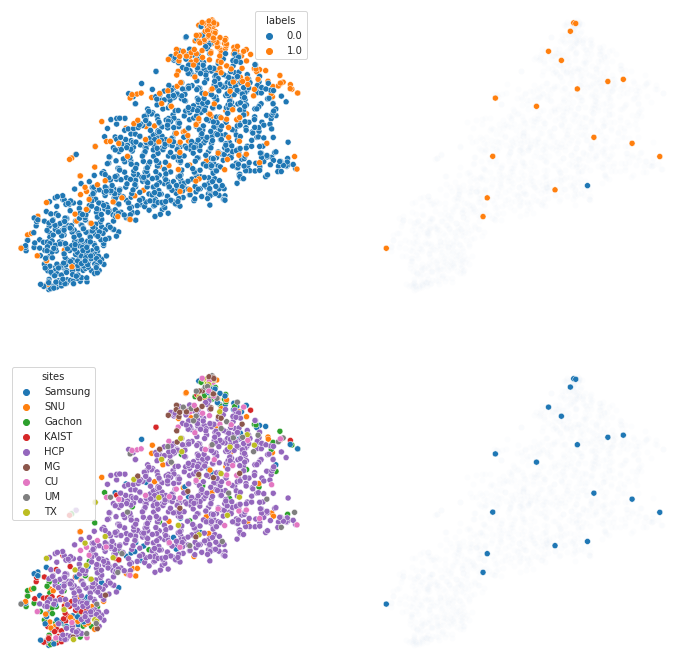

In [69]:
# tSNE
from sklearn.manifold import TSNE
emb = {"labels": labels, "outputs":outputs, "embedding":embeddings, "subject_id":subject_id}
tsne2 = TSNE(n_components=2).fit_transform( emb['embedding'] ) 
classes = ['labels', 'sites']
test_indices = [ i for i in range(len(emb['subject_id']))  if emb['subject_id'][i] in ft_test_subjects ]
# print(test_indices)
# print(split['test'])
emb['sites'] = [ parse_site(s) for s in emb['subject_id'] ]
i = 1
fig = plt.figure(figsize=(12, 12)) 
for class_name in classes:
    class_code = np.array(emb[class_name])       
    for plot_test in [False, True]: 
        ax = fig.add_subplot(2, len(classes), i)    
        sns.set_style("white")
        
        if class_name is None:
            x, y, c = tsne2[:, 0], tsne2[:, 1], class_code[:]
            tsne_df2 = pd.DataFrame({'x': x, 'y':y}) 
            sns.scatterplot( x = 'x', y = 'y', data = tsne_df2, legend = "full", ax=ax)
        else:        
            if plot_test:
                x, y = tsne2[:, 0], tsne2[:, 1]
                tsne_df2 = pd.DataFrame({'x': x, 'y':y})      
                sns.scatterplot( x = 'x', y = 'y', data = tsne_df2, ax=ax, alpha=0.01)

                x, y, c = tsne2[test_indices, 0], tsne2[test_indices, 1], class_code[test_indices]   
                tsne_df2_test = pd.DataFrame({'x': x, 'y':y, class_name:c})      
                sns.scatterplot( x = 'x', y = 'y', hue =  class_name, data =tsne_df2_test, legend="full", ax=ax)
            else:
                x, y, c = tsne2[:, 0], tsne2[:, 1], class_code[:]
                tsne_df2 = pd.DataFrame({'x': x, 'y':y, class_name:c})      
                sns.scatterplot( x = 'x', y = 'y', hue =  class_name, data = tsne_df2, legend = "full", ax=ax)
        ax.set_axis_off()
        i += 1